# Filtering, Corners and Edges

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\timho\OneDrive\Documents\Presentations\2023JuliaConImages\JuliaCon23_ImageProcessingWorkshop`


# Introduction
JuliaImages provides various filtering operations, corner algorithms and edge detection algorithms through various packages in the ecosystem. Images has good support for filtering, corner and edge detection. 

In [2]:
using Images, TestImages

Images.jl provides the support for filtering operations through ImageFiltering.jl. ImageFiltering supports linear and nonlinear filtering operations on arrays, with an emphasis on the kinds of operations used in image processing. Core operations:

| Function                 | Action         | 
|:-------------------------|:---------------|
|`imfilter` & `imfilter!`       | Filter a one, two, or multidimensional array with a kernel by computing their correlation (linear filtering) |
|`imgradients`     | Estimate the gradient of img in the direction of the first and second dimension at all points of the image, using a kernel (linear) |
|`mapwindow` & `mapwindow!`      | Apply a function to sliding windows of img (nonlinear filtering) |

Common kernels (filters) are organized in the `Kernel` and `KernelFactors` modules:
- `Kernel` has filters of the same dimensionality as your image (2d for this workshop)
- `KernelFactors` represents many of the same filters in "factored" form, e.g., `kernel[i, j] = k1[i] * k2[j]`. Especially if the kernel covers more than a few pixels, this form turns out to be more computationally efficient (`O(m+n)` operations per pixel instead of `O(m*n)`).

You can see different available kernels with `names(Kernel)` and `names(KernelFactors)`.

Let's have a sample image to use:

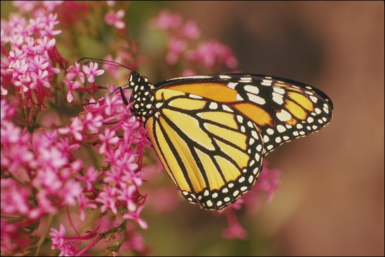

In [3]:
img = restrict(testimage("monarch"),(1,2)) # rescale 0.5 in both directions

Let's try a couple of kinds of filtering on this image. To make a blurred version of the image, we can use a Gaussian filter kernel, using the `Kernel.gaussian(σ)` function. A value of 3 (pixels) is quite blurry:

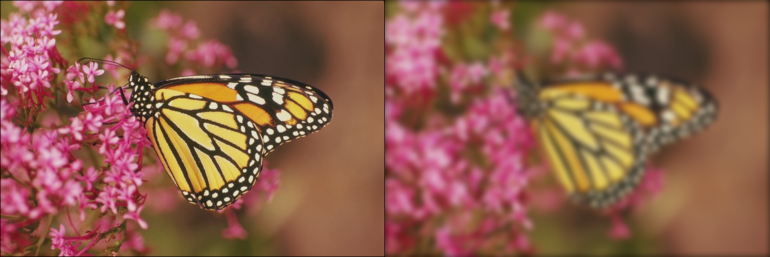

In [4]:
imgg = imfilter(img, Kernel.gaussian(3));

mosaicview(img, imgg; nrow=1)

`Kernel.gaussian(3)` is actually special syntax for the more general form `Kernel.gaussian((σ1, σ2, ...))`, where you can use a different amount of blurring in each dimension:

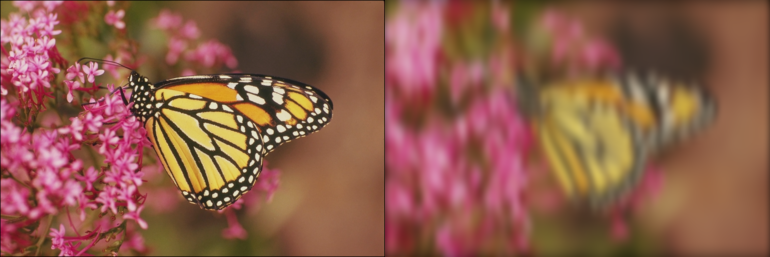

In [5]:
imgg2 = imfilter(img, Kernel.gaussian((7,3)));
mosaicview(img, imgg2; nrow=1)

If you want to blur a lot (i.e., large `σ`), the `KernelFactors.gaussian` form or especially the `KernelFactors.IIRGaussian` ("Infinite Impulse Response Gaussian" approximation) form are recommended for faster performance:

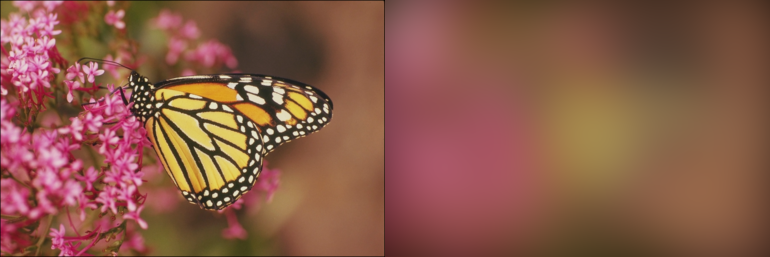

In [6]:
imgg3 = imfilter(img, KernelFactors.IIRGaussian((30,30)));
mosaicview(img, imgg3; nrow=1)

Instead of blurring, we can highlight the regions of fast change by using a `Laplacian` filter:

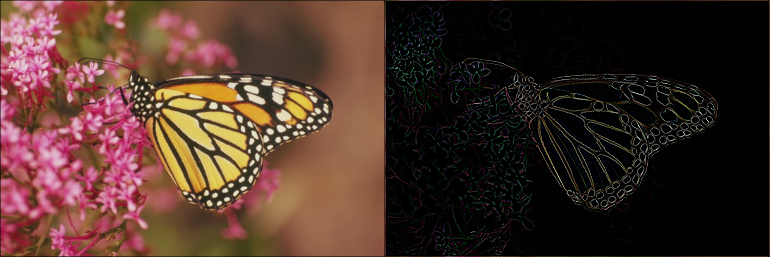

In [7]:
imgl = imfilter(img, Kernel.Laplacian());
mosaicview(img, imgl; nrow=1)

You can manually construct custom kernels from array. This 3 × 3 array in k is a good example of a sharpening filter: the central pixel will be boosted.

In [8]:
k = centered([0 -1 0 ; -1 5.5 -1 ; 0 -1 0])

3×3 OffsetArray(::Matrix{Float64}, -1:1, -1:1) with eltype Float64 with indices -1:1×-1:1:
  0.0  -1.0   0.0
 -1.0   5.5  -1.0
  0.0  -1.0   0.0

`centered` tells JuliaImages that we want the center of the kernel (array-index `0, 0`) to be in the center of that matrix:

In [9]:
k[0, 0]

5.5

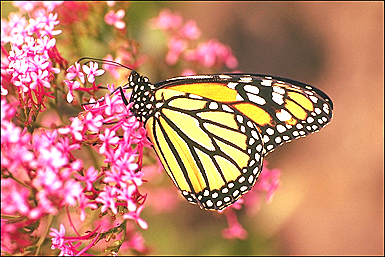

In [10]:
img3 = imfilter(img, k)

If you're building custom factored kernels, `kernelfactors` can be a useful utility:

In [11]:
k1, k2 = kernelfactors(centered.(([-1, 2, -1], [1, 0, 1, 0, 1])))
k1

Reshaped 1d stencil with axes (-1:1, 0:0):
 -1
  2
 -1

In [12]:
k2

Reshaped 1d stencil with axes (0:0, -2:2):
 1  0  1  0  1

## Nonlinear operations: applying a function to sliding windows
The `mapwindow` function provides a way to slide a rectangular "window" over an image, at each pixel returning the value of the function over the window. The window can be `m` pixels across and `n` pixels down; `m` and `n` must both be odd.

By default every pixel is visited.

This example uses a 13 × 13 window, and randomly selects just one of the 169 pixels in that window as the new value for the pixel.

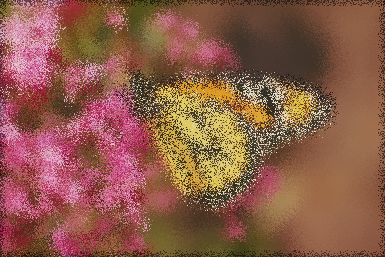

In [13]:
mapwindow(b -> b[rand(1:end)], img, (13, 13))

The result is like a dithered/downsampled version of the image.

In the next example, this short function is used to convert the buffer to gray values, find the lowest (minimum) value of the windowed area, then select the colored pixel at that point. The resulting image is thus a darker and less detailed version of the original.

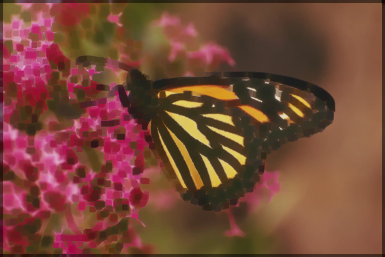

In [14]:
pixel_with_minimum_intensity(buff::AbstractArray) = argmin(Gray, buff)

mapwindow(pixel_with_minimum_intensity, img, (5, 5))

## Exercise:
- How to remove Salt and pepper noise with `mapwindow`?
- How to detect blobs using laplacian-of-Guassian (`blob_LoG`)?

# Corners and Edges
What's the difference between a corner and an edge? A corner is a junction of two edges, where an edge is a sudden change in image brightness.

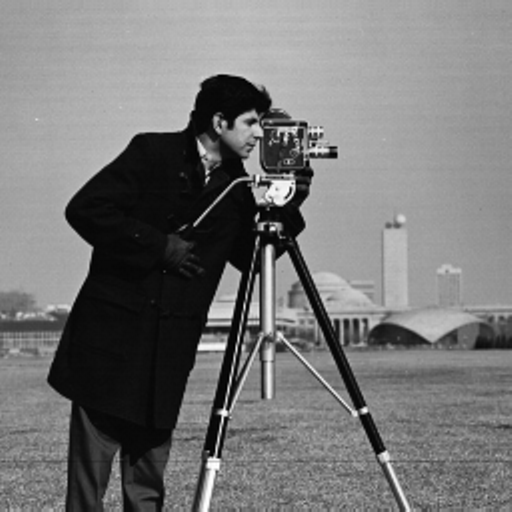

In [15]:
img = testimage("cameraman")

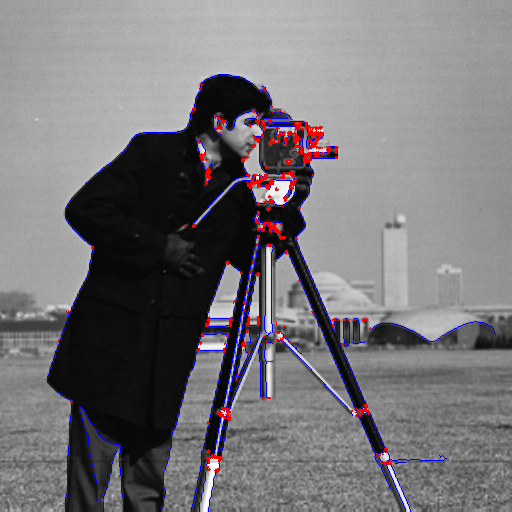

In [16]:
corners = imcorner(img, Percentile(99))
edges = canny(img, (Percentile(99), Percentile(20)))

img_copy = RGB.(img)
img_copy[edges] .= RGB(0.0, 0.0, 1.0)
img_copy[corners] .= RGB(1.0, 0.0, 0.0)
img_copy

#### Note: corners could be improved using non maxima suppression if available

Let's apply these methods on sudoku testimage if this could be useful tools!

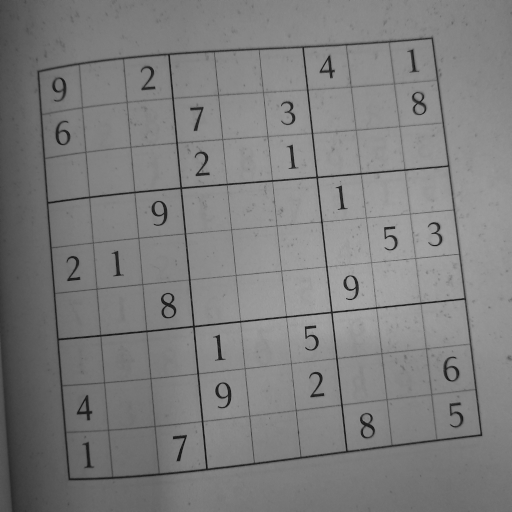

In [17]:
img_sudoku = Gray.(testimage("sudoku"))

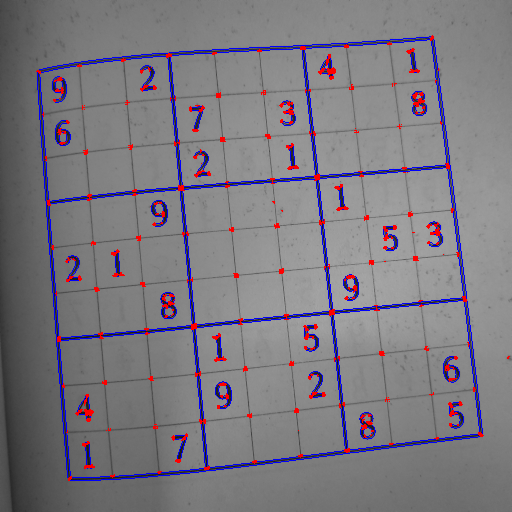

In [18]:
corners = imcorner(img_sudoku, Percentile(98.5))
edges = canny(img_sudoku, (Percentile(99), Percentile(20)))

img_copy1 = RGB.(img_sudoku)
img_copy1[edges] .= RGB(0.0, 0.0, 1.0)
img_copy1[corners] .= RGB(1.0, 0.0, 0.0)
img_copy1

This could be prove to useful information to have, and it indeed has been utilized here: https://github.com/ashwani-rathee/CameraCalibrations.jl where checkerboard edges are indetified using similar techniques.

##### Results:
| Input image     | Output Image |
| ----------- | ----------- |
| ![](assets/checkboard_1.jpg) | ![](assets/checkboard_2.png) |